# Modelo de Ising 2D

## Objetivo

Simular a curva de histerese da magnetização de um material ferromagnético no modelo de Ising pelo método de Monte Carlo.

## Parâmetros e pressupostos teóricos

Usarei aqui uma rede bidimensional quadrada de lado $\sqrt N$ sem efeitos de borda (condições de fronteira periódicas), onde todos os pontos têm 4 vizinhos.

Cada célula da rede tem um spin $s_i \in \{-1,+1\}$.

Considerei um campo magnético externo constante em todos os pontos, que denoto por $h$.

Há uma interação entre cada partícula $i$ e seus 4 vizinhos $j$, denotada por $\langle ij \rangle$. O peso (ou força) atribuído a essa interação, denotado por $J$, é modelado como constante e igual para todas as interações, e tem dimensões de energia. Ainda, $J$ é positivo, para condizer com um material ferromagnético.

A energia total de uma única configuração (microestado) do sistema é dada por

$$ H = - J\sum_{\langle ij \rangle} s_i s_j - \mu h \sum_i s_i $$

onde $\mu$ é o momento magnético. Visto que temos liberdade para definir nossas unidades de medida, simplificamos para $\mu = 1$.

Já a magnetização $M$ de um microestado é dada pela soma dos spins. Porém, estou mais interessado em estudar a magnetização por spin $m$, ou seja, a fração dos spins alinhados ao sentido positivo, tal que $-1 \leq m \leq 1$ (respectivamente, saturações mínima e máxima).


## Implementação: Monte Carlo, cadeia de Markov e algoritmo de Metropolis

A intenção é reproduzir a histerese do gráfico de magnetização vs. campo externo, ou $m \times h$.

Para tanto, vamos começar no ponto (0,0) e, ainda nesse ponto, transicionar gradualmente entre microestados desse sistema até atingir o equilíbrio termodinâmico. Entendemos "equilíbrio termodinâmico" de maneira meramente qualitativa, quando a curva de energia $H$ (ou a magnetização $M$) passa a se estabilizar ao longo de muitas transições. Uma vez estabilizada, incrementamos o campo $h$ e fazemos novamente várias transições, esperando a estabilização de $m$. Repetimos o procedimento até o ponto de saturação (ou seja, até encontrar $h$ tal que todos os spins apontam em uma só direção e a magnetização é máxima). Passamos então a decrementar $h$, novamente esperando o equilíbrio, até o ponto de saturação da magnetização mínima (todos os spins apontando na direção oposta). Nota-se que usamos um método de Monte Carlo, pois vamos apenas observar um pequeno subconjunto de microestados possíveis.

A transição entre um microestado $\lambda$ e o próximo microestado $\nu$ é feita sorteando-se uma célula da rede de maneira aleatória, com distribuição uniforme de probabilidade, e trocando-se o spin desta célula. O novo microestado $\nu$ com o spin trocado é um candidato a transição do sistema, sujeito a um teste de aceite. Esse método de encontrar novos microestados a partir do microestado imediatamente anterior satisfaz os requisitos da cadeia de Markov.

Neste esquema, podemos deduzir da equação do hamlitoniano que o módulo da diferença máxima de energia entre um microestado e o próximo é de $\Delta H_{máx} = 2J + 2|h|$.

Com a intenção de reproduzir o fundamento teórico da distribuição de probabilidades dos estados do sistema, usamos como base a distribuição de Boltzmann $e^{-\beta H_\lambda}/Z$, onde $\beta = 1/k_B T$, $k_B$ é a constante de Boltzmann, $T$ é a temperatura, $Z$ é a função de partição, e $H_\lambda$ é a energia total do sistema (hamiltoniano), baseada na soma das contribuições de cada spin e cada interação entre vizinhos. Medi a temperatura em unidades de energia, de modo que $k_B = 1$.

Porém, nota-se que esta distribuição implica uma probabilidade muito baixa de aceitar transições de estados, de forma que o algoritmo passaria muitos passos sem aceitar transições, resultando em um baixo número de microestados diferentes. Sem violar os pressupostos teóricos, podemos introduzir uma otimização e usar a taxa de aceite de transição dada pelo método de Metropolis-Hastings, que consiste em:

$$
A(\lambda \rightarrow \nu) = \left\{
\begin{array}{ll}
      e^{-\beta (H_\nu - H_\lambda)}  & , \, H_\nu - H_\lambda > 0 \\
      1 & , \, H_\nu - H_\lambda \leq 0 \\
\end{array} 
\right.
$$

Em síntese, a seleção do próximo microestado é feita sorteando-se um spin, trocando seu valor, e decidindo se o sistema muda ou não para o próximo estado com base na taxa de aceite.

## Detalhes e otimizações adicionais

Para calcular $H$ de cada microestado, precisamos somar as contribuiçoes de todos os spins e de todas as interações entre vizinhos. No entanto, para calcular $H_\nu - H_\lambda$, precisamos contabilizar apenas a diferença que uma única célula faz para o hamiltoniano, o que é muito mais eficiente. Assim, sejam $s_j$ o spin canditato a transição e $s_i$ um de seus 4 vizinhos, a cada passo calculamos apenas

$$H_\nu - H_\lambda = - J\left(\sum_{\langle i j \rangle} s_i^\nu s_j^\nu - \sum_{\langle i j \rangle} s_i^\lambda s_j^\lambda\right) - h(s_j^\nu - s_j^\lambda)\, .$$

Porém, se apenas o spin $s_j$ sofre alteração entre $\nu$ e $\lambda$, então $s_i^\nu = s_i^\lambda \, \, \, \, \forall i$, simplificando a expressão para:

$$H_\nu - H_\lambda = - J\left(\sum_{\langle i j \rangle} s_i^\lambda (s_j^\nu - s_j^\lambda)\right) - h(s_j^\nu - s_j^\lambda)$$

Ainda, como $s_j$ sempre troca, pois é o spin candidato, e sabendo que $j$ é índice de apenas um spin, temos que $s_j^\nu = - s_j^\lambda$, simplificando a

$$H_\nu - H_\lambda = - J\left(\sum_{\langle i j \rangle} s_i^\lambda (- 2s_j^\lambda)\right) - h(- 2s_j^\lambda)$$
$$  = 2s_j^\lambda \left(J\sum_i s_i^\lambda + h\right) $$


De maneira análoga, tentei implementar a diferença de magnetizações $M_\nu - M_\lambda = 2s_j^\nu / N$, mas no momento não está funcionando. No entanto, como calculamos a magnetização a cada período de vários passos, o cálculo direto não parece estar sendo tão menos eficiente.

Vale notar que adotamos uma temperatura sempre constante e baixa o suficiente para não destituir a fase ferromagnética do material.

Para selecionar aleatoriamente um único spin, em vez de atribuir um número único a cada célula e, deste número, obter o seu endereço em termos de linha e coluna, o que envolveria cálculos adicionais, sorteei dois números, um para sua linha e outro para sua coluna, pressupondo serem estatisticamente independentes, sendo possível obter a mesma distribuição de probabilidades de um número único (distribuição conjunta) via marginalização.

Possível otimização futura: calculo a priori das possibilidades de exponenciais.

## Visualizações

### Magnetização ao longo de uma cadeia de Markov

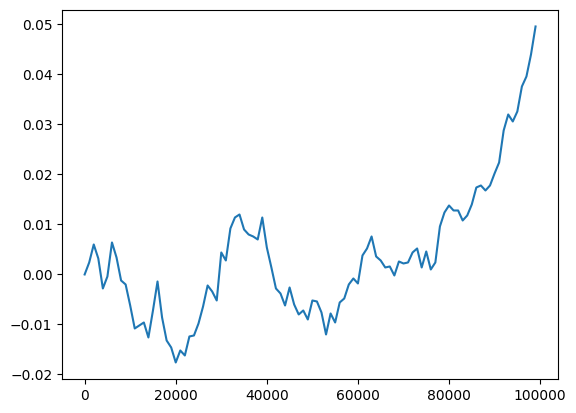

In [49]:
import pandas as pd
from matplotlib import pyplot as plt

tabela_magnetizacao = pd.read_csv("dados-2a-tentativa/l1p1h0/tabela-t-m.csv")

plt.plot(tabela_magnetizacao['t'], tabela_magnetizacao['m'])

### Rede inicial com magnetizacao 0

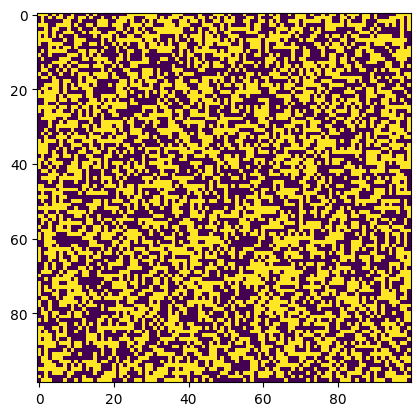

In [28]:
rede_inicial = pd.read_csv("dados-2a-tentativa/rede-inicial.csv")
plt.imshow(rede_inicial, cmap='viridis')

### Rede após uma cadeia de Markov

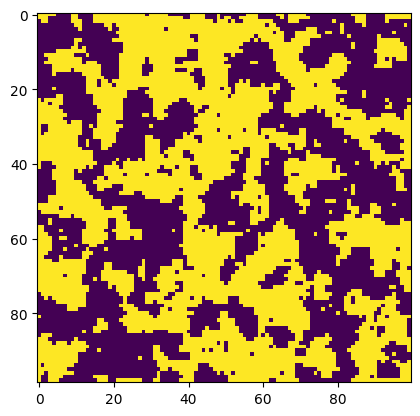

In [29]:
rede = pd.read_csv("dados-2a-tentativa/l1p1h0/rede-final.csv")
plt.imshow(rede, cmap='viridis')

### Rede na configuração saturada

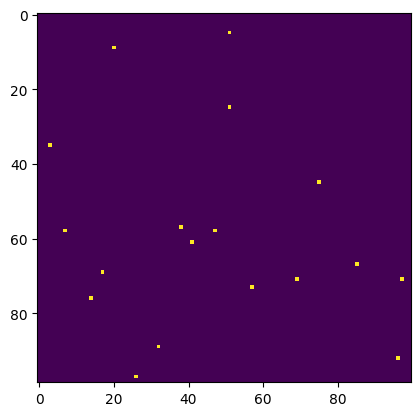

In [47]:
rede = pd.read_csv("dados-2a-tentativa/l1p3h-2/rede-final.csv")
plt.imshow(rede, cmap='viridis')

### Curva de Histerese

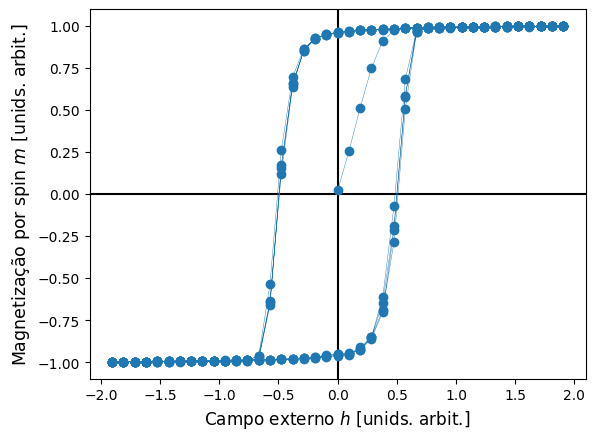

In [46]:
histerese = pd.read_csv("dados-2a-tentativa/histerese/um_loop.csv")
plt.axhline(0, color='black', zorder = 1)
plt.axvline(0, color='black', zorder = 1)
plt.scatter(histerese['h'], histerese.iloc[:,2], zorder = 2)
plt.ylabel("Magnetização por spin $m$ [unids. arbit.]", size=12.5)
plt.xlabel("Campo externo $h$ [unids. arbit.]", size = 12.2)
plt.plot(histerese['h'], histerese.iloc[:,2], linewidth=.3, zorder = 2)